In [1]:
import numpy as np
import networkx as nx
import netrd
import matplotlib.pyplot as plt
import itertools as it
import pickle

plt.rc('axes', axisbelow=True)
%matplotlib inline

- __[Visit the ReadTheDocs](https://netrd.readthedocs.io/en/latest/)__

In [2]:
def simulate(G, L, num_seeds=1, beta=None, mu=None, dontdie=False):
    r"""Simulate SIS model dynamics on a network.

    The results dictionary also stores the ground truth network as
    `'ground_truth'`.

    Parameters
    ----------
    G (nx.Graph)
        the input (ground-truth) graph with :math:`N` nodes.

    L (int)
        the length of the desired time series.

    num_seeds (int)
        the number of initially infected nodes.

    beta (float)
        the infection rate for the SIS process.

    mu (float)
        the recovery rate for the SIS process.

    Returns
    -------
    TS (np.ndarray)
        an :math:`N \times L` array of synthetic time series data.

    """
    H = G.copy()
    N = H.number_of_nodes()
    TS = np.zeros((N, L))
    index_to_node = dict(zip(range(G.order()), list(G.nodes())))

    # sensible defaults for beta and mu
    if not beta:
        avg_k = np.mean(list(dict(H.degree()).values()))
        beta = 1 / avg_k
    if not mu:
        mu = 1 / H.number_of_nodes()

    seeds = np.random.permutation(
        np.concatenate([np.repeat(1, num_seeds), np.repeat(0, N - num_seeds)])
    )
    TS[:, 0] = seeds
    infected_attr = {index_to_node[i]: s for i, s in enumerate(seeds)}
    nx.set_node_attributes(H, infected_attr, 'infected')
    nx.set_node_attributes(H, 0, 'next_infected')

    # SIS dynamics
    num_dontdie=0
    for t in range(1, L):
        #print('Test')
        nodes = np.random.permutation(H.nodes)
        for i in nodes:
            if H.nodes[i]['infected']:
                neigh = H.neighbors(i)
                for j in neigh:
                    if np.random.random() < beta:
                        H.nodes[j]['next_infected'] = 1
                if np.random.random() >= mu:
                    H.nodes[i]['next_infected'] = 1
        infections = nx.get_node_attributes(H, 'infected')
        next_infections = nx.get_node_attributes(H, 'next_infected')
        #print(infections)
        #print(next_infections==0)
        if dontdie and all([x==0 for x in next_infections.values()]):
            #print('dontdie')
            num_dontdie += 1
            key = list(infections.keys())[list(infections.values()).index(1)]
            next_infections[key] = 1

        # store SIS dynamics for time t
        TS[:, t] = np.array(list(infections.values()))
        nx.set_node_attributes(H, next_infections, 'infected')
        nx.set_node_attributes(H, 0, 'next_infected')

        # if the epidemic dies off, stop
        if TS[:, t].sum() < 1:
            break
    print('num_dontdie: ' + str(num_dontdie))
    # if the epidemic died off, pad the time series to the right shape
    if TS.shape[1] < L:
        TS = np.hstack([TS, np.zeros((N, L - TS.shape[1]))])

    #self.results['ground_truth'] = H
    #self.results['TS'] = TS
    #self.results['index_to_node'] = index_to_node

    return TS

In [42]:
np.random.seed(0)
num_nodes=20
G0 = nx.barabasi_albert_graph(num_nodes, 2, seed=0)
#G0 = nx.bull_graph()
D0 = netrd.dynamics.SISModel()
#D0 = netrd.dynamics.VoterModel()
#D0 = netrd.dynamics.Kuramoto()

# get average degree of the network
k_avg = np.mean(list(dict(G0.degree()).values()))
# how long should the time series be?
L  = 10000
# simulate D0 dynamics on the network
num_runs=1
TS = np.zeros((num_nodes,num_runs*L))
for i in range(num_runs):
    TS[:,i*L:(i+1)*L] = simulate(G0, L, num_seeds=2, beta=0.1, mu=0.1,dontdie=True) #beta=0.2, mu=0.2, dontdie=True) <- this was used for SIS brute force datagen
    #TS[:,i*L:(i+1)*L] = D0.simulate(G0, L, num_seeds=10, beta=0.44, mu=0.1)#beta=0.33, mu=0.1)
    #TS[:,i*L:(i+1)*L] = D0.simulate(G0, L)
    #TS[:,i*L:(i+1)*L] = D0.simulate(G0, L, dt=0.1, strength=.5, phases=None, freqs=None)
print(TS.shape)
#print(TS)

num_dontdie: 0
(20, 10000)


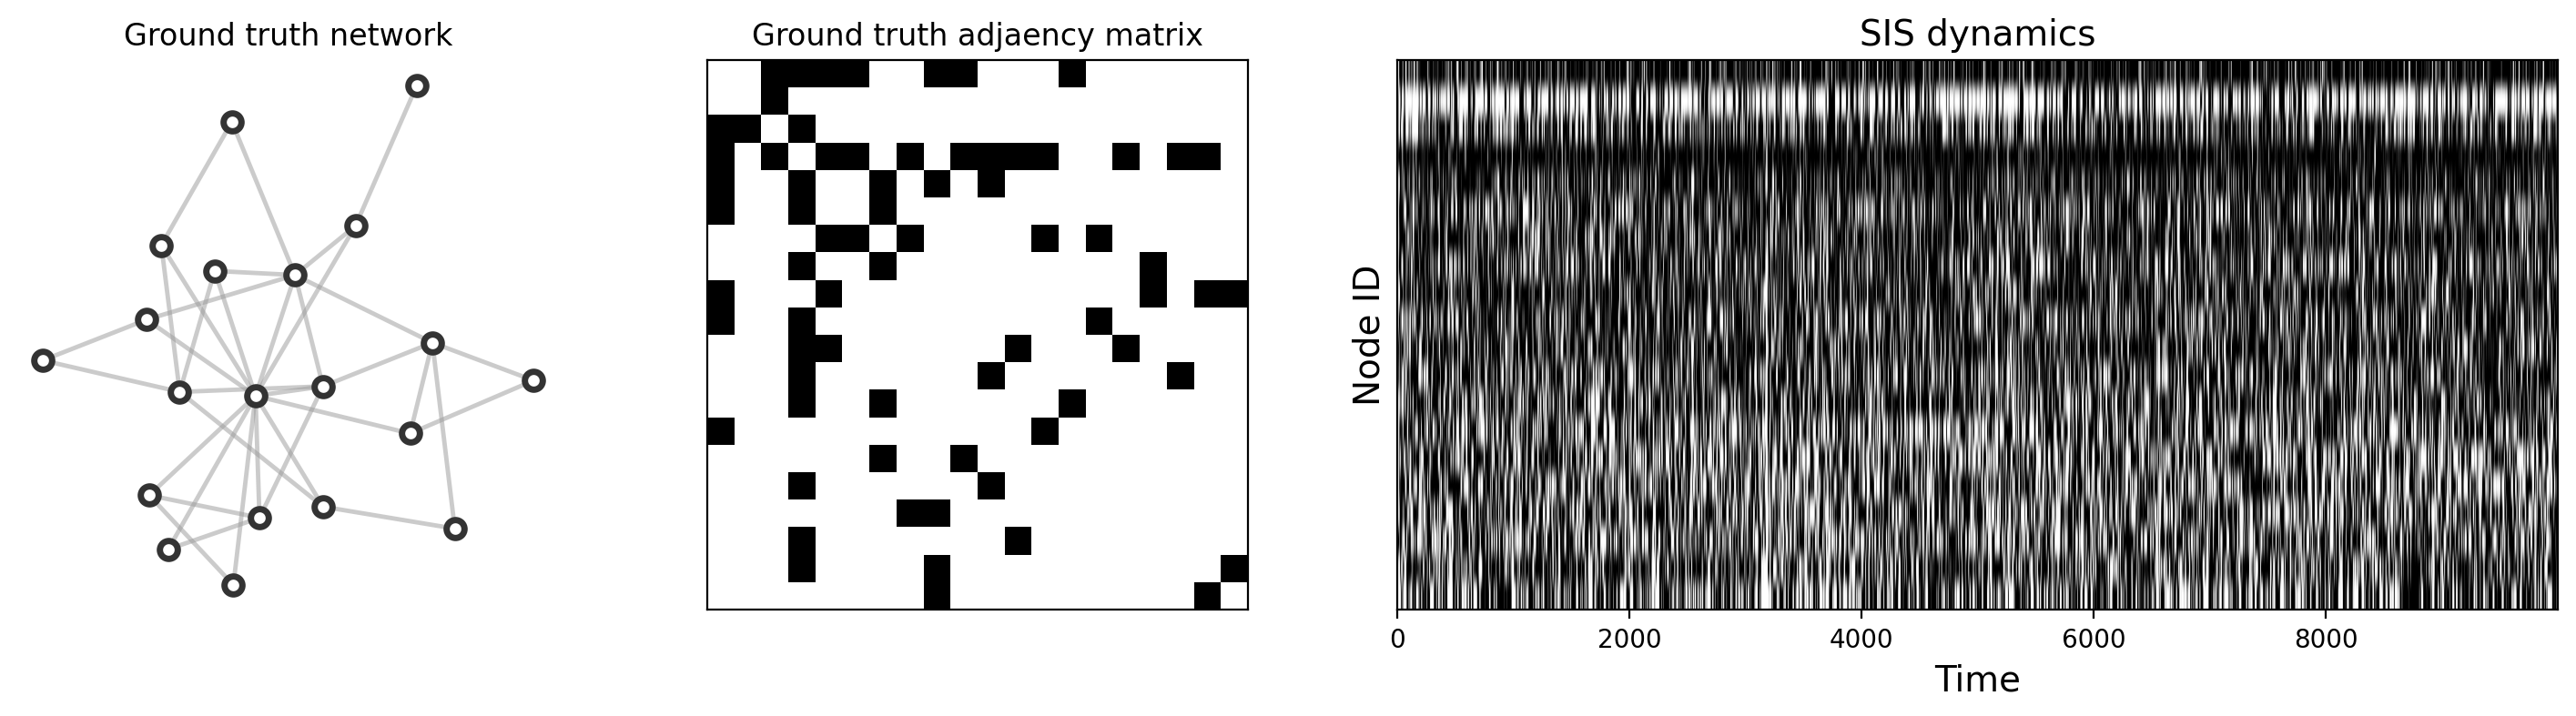

In [43]:
fig, ax = plt.subplots(1,3,figsize=(18,4),gridspec_kw={'width_ratios':[1,1,2.15]},dpi=200)

pos = nx.kamada_kawai_layout(G0)

nx.draw_networkx_nodes(G0, pos, node_size=50, node_color='w', linewidths=2.5, edgecolors='.2', ax=ax[0])
nx.draw_networkx_edges(G0, pos, width=1.75, edge_color='.6', alpha=0.5, ax=ax[0])
ax[0].set_title("Ground truth network")
ax[0].set_axis_off()

ax[1].imshow(nx.to_numpy_array(G0), cmap='Greys', aspect='auto')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title("Ground truth adjaency matrix")

ax[2].imshow(TS, cmap='Greys', aspect='auto')
ax[2].set_yticks([])
ax[2].set_xlabel("Time", size=14)
ax[2].set_ylabel("Node ID", size=14)
ax[2].set_title("%s dynamics"%'SIS', size=14)


plt.show()

In [44]:
# export time series
transposed = TS.transpose()
print(transposed.shape)
seriespath = r'D:\Uni\BA\Development\data\final\netrd\SIS\timeseries_ba20_10k_0.1.pickle'
#matrixpath = r'D:\Uni\BA\Development\data\netrd\SIS\edges_bull.pickle'
with open(seriespath, 'wb') as f:
    pickle.dump(transposed, f)
#with open(matrixpath, 'wb') as f:
#    pickle.dump(nx.to_numpy_matrix(G0), f)

(10000, 20)


### Visualization

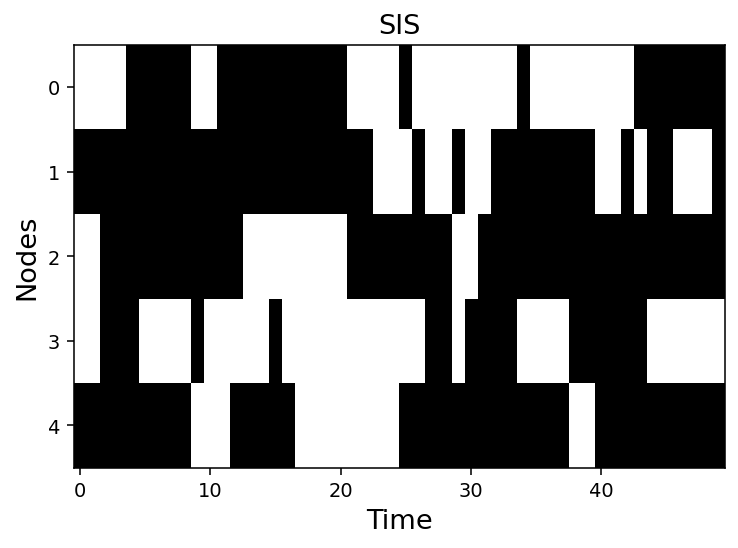

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=140)#gridspec_kw={'width_ratios':[1,1,2.15]},dpi=200)

ax.imshow(TS[:,0:50], cmap='Greys', aspect='auto', interpolation='none')
#ax.set_yticks([])
ax.set_xlabel("Time", size=14)
ax.set_ylabel("Nodes", size=14)
ax.set_title("SIS", size=14)


plt.show()

In [11]:
fig.savefig(r"D:\Uni\BA\notebooks\netrd_notebooks\timeseries_plots\SIS_0.2.png", dpi=140,pad_inches=0)

### Using the time series above (right), we want to reconstruct the adjacency matrix (middle)

In [7]:
# dictionary of some of the reconstruction techniques in netrd
# (leaving out some of the more computationally expensive ones)
recons = {
    #'ConvergentCrossMapping':       netrd.reconstruction.ConvergentCrossMapping(),
    'CorrelationMatrix':            netrd.reconstruction.CorrelationMatrix(),
    #'ExactMeanField':               netrd.reconstruction.MeanField(),
    #'FreeEnergyMinimization':       netrd.reconstruction.FreeEnergyMinimization(),
    #'GraphicalLasso':               netrd.reconstruction.GraphicalLasso(),
    #'MarchenkoPastur':              netrd.reconstruction.MarchenkoPastur(),
    #'MaximumLikelihoodEstimation':  netrd.reconstruction.MaximumLikelihoodEstimation(),
    'MutualInformationMatrix':      netrd.reconstruction.MutualInformationMatrix(),
    #'OUInference':                  netrd.reconstruction.OUInference(),
    #'ThoulessAndersonPalmer':       netrd.reconstruction.ThoulessAndersonPalmer(),
    'GrangerCausality':             netrd.reconstruction.GrangerCausality(),
    'PartialCorrelationMatrix':     netrd.reconstruction.PartialCorrelationMatrix()}
    #'PartialCorrelationInfluence':  netrd.reconstruction.PartialCorrelationInfluence()}

In [8]:
# for ease of visualization, we'll threshold all the reconstructions 
kwargs = {'threshold_type':'degree', 'avg_k':k_avg}

# dictionary to store the outputs
Wdict = {}

# loop over all the reconstruction techniques
for ri, R1 in list(recons.items()):
    R1.fit(TS, **kwargs)
    Wr = R1.results['thresholded_matrix']
    Wdict[ri] = Wr

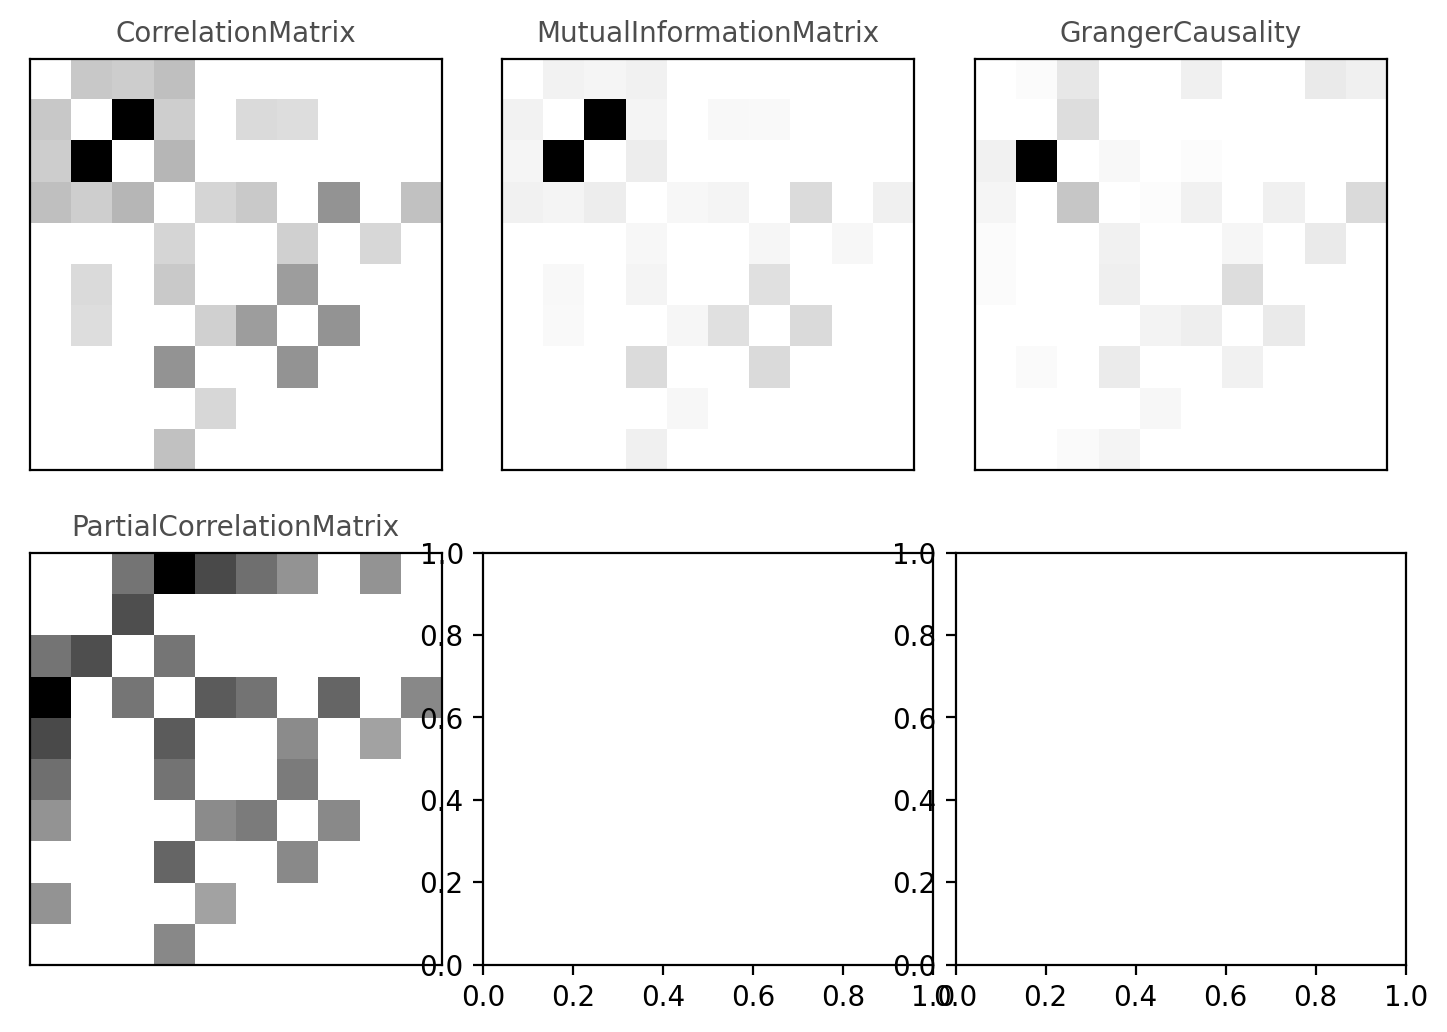

In [9]:
w = 3.0; h = 3.0
ncols = 3; nrows = 2
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)
plt.subplots_adjust(wspace=0.05,hspace=0.2)

ix = 0
for lab_i, W_i in Wdict.items():
    a = ax[tups[ix]]
    a.imshow(W_i, cmap='Greys')
    ix += 1
    a.set_title(lab_i, color='.3', fontsize='medium')
    a.set_yticks([])
    a.set_xticks([])

plt.show()